<a href="https://colab.research.google.com/github/mancunian1792/causal_scene_generation/blob/master/causal_model/game_characters/GameCharacter_ImageClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive

drive.mount("/content/gdrive", force_remount=True)



Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import to_categorical
from keras.preprocessing import image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from tqdm import tqdm
from skimage.transform import rotate
from skimage.util import random_noise
from skimage.filters import gaussian

Using TensorFlow backend.


In [ ]:
root_path = 'gdrive/My Drive/causal_scene_generation/game_characters/'

In [ ]:
train_path = root_path + 'train/'
test_path = root_path + 'test/'

train_images = train_path + 'images/'
test_images = test_path + 'images/'
train_csv = train_path + 'train.csv'
test_csv = test_path + 'test.csv'

In [ ]:
def preprocess(imgPath, filePath):
  images = []
  # Transform each image in the imgPath and add it to the input array
  data = pd.read_csv(filePath)

  for imgFile in tqdm(data["filename"]):
    imgFullPath = imgPath + imgFile + ".png"
    img = image.load_img(imgFullPath, target_size=(400,400,3), grayscale=False)
    img = image.img_to_array(img)
    img = img/255
    images.append(img)
  features = np.array(images)

  # Get the labels for each 
  target = data.drop(["filename"], axis=1)
  return features, target


In [ ]:
def augmentData(features, target):
  augmented_features = []
  augmented_target = []
  for idx in tqdm(range(features.shape[0])):
    augmented_features.append(features[idx])
    augmented_features.append(rotate(features[idx], angle=45, mode = 'wrap'))
    augmented_features.append(np.fliplr(features[idx]))
    augmented_features.append(np.flipud(features[idx]))
    augmented_features.append(random_noise(features[idx],var=0.2**2))
    for i in range(5):
      augmented_target.append(target.iloc[idx, :])
  return np.asarray(augmented_features), pd.DataFrame(augmented_target, columns= target.columns)

In [ ]:
x_train, y_train = preprocess(train_images, train_csv)

100%|██████████| 345/345 [01:21<00:00,  4.25it/s]


In [ ]:
x_train_augment, y_train_augment = augmentData(x_train, y_train)
del x_train, y_train

100%|██████████| 345/345 [00:18<00:00, 19.13it/s]


In [ ]:
x_test, y_test = preprocess(test_images, test_csv)

100%|██████████| 87/87 [00:17<00:00,  5.05it/s]


In [ ]:
x_test, x_validate, y_test, y_validate = train_test_split(x_test, y_test, random_state = 3000, test_size = 0.2)

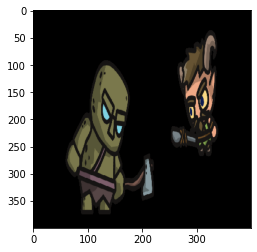

In [ ]:
plt.imshow(x_validate[2])

In [ ]:
# Size of vector is 64 * 64 * 3 -> resize ((64 *64*3), 1)
#  (/255 )

# Convert to grayscale.-> 

# The output shape 
op_shape = y_train_augment.shape[1]

In [ ]:
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=(5, 5), activation="relu", input_shape=(400,400,3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters=32, kernel_size=(10, 10), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters=64, kernel_size=(10, 10), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters=64, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(op_shape, activation='sigmoid'))

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 396, 396, 16)      1216      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 198, 198, 16)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 198, 198, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 189, 189, 32)      51232     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 94, 94, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 94, 94, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 85, 85, 64)       

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model.fit(x_train_augment, y_train_augment, epochs=10, validation_data=(x_test, y_test), batch_size=64)

Train on 1725 samples, validate on 69 samples
Epoch 1/10
1725/1725 [==============================] - 1190s 690ms/step - loss: 0.5421 - accuracy: 0.7570 - val_loss: 0.5140 - val_accuracy: 0.8210
Epoch 2/10
1725/1725 [==============================] - 1184s 687ms/step - loss: 0.5091 - accuracy: 0.7773 - val_loss: 0.4775 - val_accuracy: 0.8242
Epoch 3/10
1725/1725 [==============================] - 1187s 688ms/step - loss: 0.4734 - accuracy: 0.7948 - val_loss: 0.4355 - val_accuracy: 0.8299
Epoch 4/10
1725/1725 [==============================] - 1184s 686ms/step - loss: 0.4450 - accuracy: 0.8013 - val_loss: 0.3910 - val_accuracy: 0.8368
Epoch 5/10
1725/1725 [==============================] - 1184s 686ms/step - loss: 0.4258 - accuracy: 0.8045 - val_loss: 0.3662 - val_accuracy: 0.8355
Epoch 6/10
1725/1725 [==============================] - 1186s 688ms/step - loss: 0.4101 - accuracy: 0.8098 - val_loss: 0.3813 - val_accuracy: 0.8431
Epoch 7/10
1725/1725 [==============================] - 1200

In [ ]:
model.save(root_path+"model-both-images.hdf5")

In [ ]:
prediction = model.predict(x_validate)

In [ ]:
prediction[0]

array([0.05412871, 0.9452934 , 0.0415864 , 0.04666784, 0.05643195,
       0.36952862, 0.4217787 , 0.32277754, 0.24282143, 0.39766943,
       0.44778284, 0.96283925, 0.03289306, 0.37926552, 0.2857697 ,
       0.40201467, 0.02193752, 0.03831947, 0.0361236 , 0.30381364,
       0.27687413, 0.39059502, 0.21380812], dtype=float32)

In [ ]:
del x_train_augment, y_train_augment, x_test, y_test

### Attempt 2 - Image Classification
This time, i am splitting the images and modify the labels. The image classification will try to predict the entity (actor/reactor), character(satyr/golem), type(1/2/3) and entity_doing (action/reaction) and entity_doing_type(Idle/Attacking/Hurt/Die/Walking/Taunt)

In [ ]:
# Modify the labels (Do - encoding)
splits_path = root_path + 'splits/'
splits_images = splits_path + 'images/'
splits_dataset = splits_path + 'split_dataset.csv'

In [ ]:
df = pd.read_csv(splits_dataset)

In [ ]:
df["type"] = df.type.str.extract('(\d+)')

In [ ]:
images = df["img_name"]
target = df.drop(["img_name"], axis=1)
target = pd.get_dummies(target)

In [ ]:
def processSplitImages(imgPath, filenames):
  images_data = []
  for img in tqdm(filenames):
    imgFullPath = imgPath + img + ".png"
    img = image.load_img(imgFullPath, target_size=(400,400,3), grayscale=False)
    img = image.img_to_array(img)
    img = img/255
    images_data.append(img)
  features = np.array(images_data)
  return features

In [ ]:
img_features = processSplitImages(splits_images, images)

100%|██████████| 864/864 [05:21<00:00,  2.68it/s]


In [ ]:
# Split into train and test . And then augment the train data.
features_train, features_test, target_train, target_test = train_test_split(img_features, target, stratify=target, test_size=0.2)
del img_features, target

In [ ]:
# Augmenting train data -> Not able to allocate enough RAM
#feature_train_augmented, target_augmented = augmentData(features_train, target_train)

100%|██████████| 691/691 [00:38<00:00, 17.82it/s]


In [ ]:
op_shape = target_train.shape[1]

In [ ]:
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=(5, 5), activation="relu", input_shape=(400,400,3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters=32, kernel_size=(10, 10), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters=64, kernel_size=(10, 10), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters=64, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(op_shape, activation='sigmoid'))

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
from keras.callbacks import ModelCheckpoint

filepath=root_path + "weights-{epoch:02d}-{val_accuracy:.3f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy',
                               verbose=1, mode='max')

callbacks_list = [checkpoint]
model.fit(features_train, target_train, epochs=10, validation_data=(features_test, target_test), batch_size=64, callbacks=callbacks_list)

Train on 691 samples, validate on 173 samples
Epoch 1/10
691/691 [==============================] - 511s 739ms/step - loss: 0.6233 - accuracy: 0.6616 - val_loss: 0.6088 - val_accuracy: 0.8224

Epoch 00001: saving model to gdrive/My Drive/causal_scene_generation/game_characters/weights-01-0.822.hdf5
Epoch 2/10
691/691 [==============================] - 507s 733ms/step - loss: 0.5335 - accuracy: 0.7487 - val_loss: 0.4891 - val_accuracy: 0.8482

Epoch 00002: saving model to gdrive/My Drive/causal_scene_generation/game_characters/weights-02-0.848.hdf5
Epoch 3/10
691/691 [==============================] - 503s 727ms/step - loss: 0.4832 - accuracy: 0.7785 - val_loss: 0.4509 - val_accuracy: 0.8647

Epoch 00003: saving model to gdrive/My Drive/causal_scene_generation/game_characters/weights-03-0.865.hdf5
Epoch 4/10
691/691 [==============================] - 504s 729ms/step - loss: 0.4373 - accuracy: 0.8068 - val_loss: 0.4061 - val_accuracy: 0.8844

Epoch 00004: saving model to gdrive/My Drive/